Filter method to select top 16 features...
['CRASH_TYPE_Struck pedestrian (On Road)', 'CRASH_TYPE_Rear end collision', 'CRASH_TYPE_Overturned (On Road)', 'CRASH_TYPE_Right turn into oncoming vehicle', 'CRASH_TYPE_Struck object (Off Road)', 'CRASH_TYPE_Right angle collision', 'CRASH_TYPE_Struck pedestrian (Off Road)', 'CRASH_TYPE_Head on collision', 'SUBURB_LOCATION_RURAL - COREE', 'SUBURB_LOCATION_RURAL - PADDYS  RIVER', 'CRASH_TYPE_Other - Vehicle to Vehicle', 'CRASH_TYPE_Overturned (Off Road)', 'CRASH_TYPE_Same direction side swipe', 'CRASH_TYPE_Fall from moving vehicle (On Road)', 'CRASH_TYPE_Collision while one vehicle reversing', 'LIGHTING_CONDITION_Daylight']
done


/mnt/d/chris/documents/uni/comsci/comp9417/project/models/random_forest.py:45: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(data.X_train, data.y_train)


Accuracy: 0.9205884403541797
Recall: 0.5519924563484038
Precision: 0.7744038774499399
F1 Score: 0.5726323653998813
Test Fatals: 0
Test non-property damage: 1191


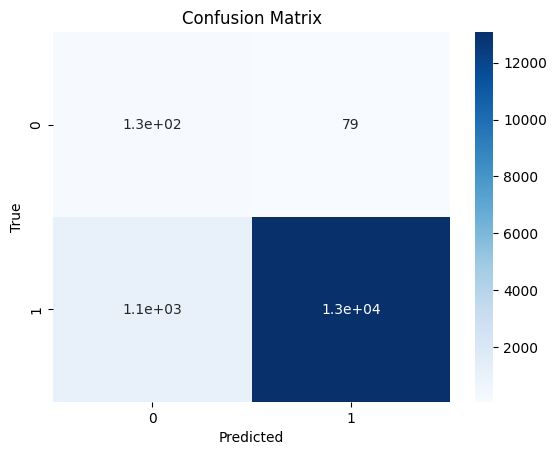

In [17]:
import pandas as pd
from datasets import Datasets
from model_evaluation import Evaluation
import numpy as np
import random_forest

pth = "../"
data = Datasets(pth + "X_train.csv", pth + "X_test.csv", pth + "X_val.csv",
                pth + "y_train_binary.csv", pth + "y_test_binary.csv", pth + "y_val_binary.csv")

# def feature_select_pearson(train, test):
print('Filter method to select top 16 features...')
train = data.X_train
val = data.X_val
test = data.X_test
target = "CRASH_SEVERITY"
train[target] = data.y_train[target]
train[target].replace(('Property Damage Only', 'Injury or Fatal'), (1, 0), inplace=True)
features = train.columns.tolist()
# features.remove("CRASH_ID")
features.remove(target)
featureSelect = features[:]
# print(features) # 178 features

# print(featureSelect)
# remove features with a missing value ratio greater than 0.99
for feature in features:
    if train[feature].isnull().sum() / train.shape[0] >= 0.99:
        featureSelect.remove(feature)

# calculate the pearson correlation
corr = []
for feature in featureSelect:
    # print(train[[feature, target]])
    corr.append(abs(train[[feature, target]].fillna(0).corr().values[0][1]))

# get top 16 features with the highest correlation
se = pd.Series(corr, index=featureSelect).sort_values(ascending=False)
feature_select = se[:16].index.tolist()
print(feature_select)
print('done')
# print(train[feature_select + [target]], test[feature_select + [target]])
# return train[feature_select + [target]], test[feature_select + [target]]

data.X_train = train[feature_select]
data.X_val = val[feature_select]
data.X_test = test[feature_select]

train[feature_select].to_csv('X_train_filter.csv')
val[feature_select].to_csv('X_val_filter.csv')
test[feature_select].to_csv('X_test_filter.csv')

# Testing random forest with filtered features
RF_y_pred = random_forest.RF(data)

# Random Forest
eva = Evaluation()
print("Accuracy:", eva.accuracy(RF_y_pred, data.y_test))
print("Recall:", eva.recall(RF_y_pred, data.y_test))
print("Precision:", eva.precision(RF_y_pred, data.y_test))
print("F1 Score:", eva.f1_score(RF_y_pred, data.y_test))
print("Test Fatals:", np.count_nonzero(data.y_test == "Fatal"))
print("Test non-property damage:", np.count_nonzero(data.y_test == "Injury or Fatal"))
eva_conf = eva.confusion(RF_y_pred, data.y_test)
eva.plot_confusion(eva_conf)
